In [1]:
from __future__ import division, print_function, absolute_import

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

/Users/sanghyub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/sanghyub/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/sanghyub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

/Users/sanghyub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from t

In [9]:
mnist.train.images.shape

(55000, 784)

In [3]:
#parameters
learning_rate = 0.001
num_steps = 30000
batch_size = 64

In [10]:
#network parameters
image_dim = 784
hidden_dim = 512
latent_dim = 2

In [42]:
#Xabier init
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1./tf.sqrt(shape[0]/2.))

In [43]:
# Variables
weights = {
    'encoder_h1': tf.Variable(glorot_init([image_dim, hidden_dim])),
    'z_mean': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'z_std': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim, image_dim]))
}
biases = {
    'encoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    'z_std': tf.Variable(glorot_init([latent_dim])),
    'decoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}

In [44]:
# Building the encoder
input_image = tf.placeholder(tf.float32, shape=[None, image_dim])
encoder = tf.matmul(input_image, weights['encoder_h1']) + biases['encoder_b1']
encoder = tf.nn.tanh(encoder)
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']

# Sampler: Normal (gaussian) random distribution
# Reparameterization trick
eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0,
                       name='epsilon')
z = z_mean + tf.exp(z_std / 2) * eps

# Building the decoder (with scope to re-use these layers later)
decoder = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

In [45]:
# Define VAE Loss(kl divergence in normal distribution)
def vae_loss(x_reconstructed, x_true):
    # Reconstruction loss
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    # KL Divergence loss
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)

In [46]:
loss_op = vae_loss(decoder, input_image)
optimizer = tf.train.RMSPropOptimizer(learning_rate =learning_rate)
train_op = optimizer.minimize(loss_op)

In [47]:
# initialize the variables
init = tf.global_variables_initializer()

In [48]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)

    # Train
    feed_dict = {input_image: batch_x}
    _, l = sess.run([train_op, loss_op], feed_dict=feed_dict)
    if i % 1000 == 0 or i == 1:
        print('Step %i, Loss: %f' % (i, l))

Step 1, Loss: 637.824158
Step 1000, Loss: 189.014954
Step 2000, Loss: 153.197693
Step 3000, Loss: 155.222198
Step 4000, Loss: 166.522964
Step 5000, Loss: 172.821228
Step 6000, Loss: 156.584381
Step 7000, Loss: 158.191437
Step 8000, Loss: 164.576355
Step 9000, Loss: 152.712387
Step 10000, Loss: 156.132599
Step 11000, Loss: 150.270279
Step 12000, Loss: 153.833633
Step 13000, Loss: 157.205078
Step 14000, Loss: 166.031342
Step 15000, Loss: 162.508820
Step 16000, Loss: 151.549133
Step 17000, Loss: 146.472000
Step 18000, Loss: 153.917435
Step 19000, Loss: 154.433487
Step 20000, Loss: 151.818558
Step 21000, Loss: 147.058884
Step 22000, Loss: 147.681213
Step 23000, Loss: 151.027954
Step 24000, Loss: 143.351166
Step 25000, Loss: 158.888275
Step 26000, Loss: 148.960052
Step 27000, Loss: 142.049454
Step 28000, Loss: 156.575256
Step 29000, Loss: 148.526917
Step 30000, Loss: 151.174500


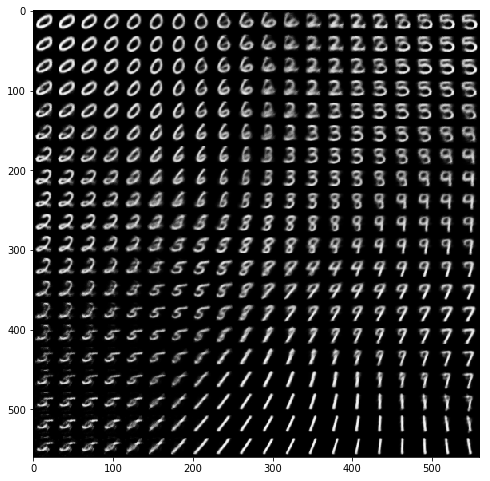

In [49]:
# Testing
# Generator takes noise as input
noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])
# Rebuild the decoder to create image from noise
decoder = tf.matmul(noise_input, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

# Building a manifold of generated digits
n = 20
x_axis = np.linspace(-3, 3, n)
y_axis = np.linspace(-3, 3, n)

canvas = np.empty((28 * n, 28 * n))
for i, yi in enumerate(x_axis):
    for j, xi in enumerate(y_axis):
        z_mu = np.array([[xi, yi]] * batch_size)
        x_mean = sess.run(decoder, feed_dict={noise_input: z_mu})
        canvas[(n - i - 1) * 28:(n - i) * 28, j * 28:(j + 1) * 28] = \
        x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))
Xi, Yi = np.meshgrid(x_axis, y_axis)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()